In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# Load dataset

We'll load a subset of the original training set for exploation purposes (subset was sampled using the 'subsample' library)

In [9]:
!subsample -n 200000 train.csv -r > train_subsample.csv

LOG 13:17 > Data begins at 163


In [27]:
train_data = pd.read_csv("train_subsample.csv")
train_data.head(5)

id  vendor_id      pickup_datetime  passenger_count  \
0  id3591560          1  2016-05-06 16:04:48                1   
1  id2377394          1  2016-06-12 00:43:35                1   
2  id3858529          2  2016-01-19 11:35:24                1   
3  id1337282          2  2016-04-14 14:57:45                1   
4  id1758131          2  2016-03-12 17:17:55                6   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.980980        40.733521         -73.975594         40.749290   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.002625        40.739555         -74.003227         40.749153   
4        -73.964645        40.791779         -73.959076         40.777885   

  store_and_fwd_flag     dropoff_datetime  trip_duration  
0                  N  2016-05-06 16:15:13            625  
1                  N  2016-06-12 00:54:38            663  
2                  N  2016-01-19 12:10:48           2124  
3                  N  2016-04-14 15:08:05            620  
4                  N  2016-03-12 17:24:16            381

## Data fields

* id - a unique identifier for each trip

* vendor_id - a code indicating the provider associated with the trip record

* pickup_datetime - date and time when the meter was engaged

* dropoff_datetime - date and time when the meter was disengaged

* passenger_count - the number of passengers in the vehicle (driver entered value)

* pickup_longitude - the longitude where the meter was engaged

* pickup_latitude - the latitude where the meter was engaged

* dropoff_longitude - the longitude where the meter was disengaged

* dropoff_latitude - the latitude where the meter was disengaged

* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

* trip_duration - duration of the trip in seconds

The 'dropoff_datetime' feature won't appear in the test-set, so we'll move this column to the one-before-last column for easier feature indexing in the training set and test set.

In [29]:
columns = list(train_data.columns)
swapped_cols = columns[:3] + columns[4:-1] + [columns[3]] + [columns[-1]]
    
for csv_name in ['train', 'train_subsample', 'train_clean']:
    df = pd.read_csv(f"{csv_name}.csv")
    df = df.reindex(columns=swapped_cols) 
    df.to_csv(f"{csv_name}.csv", index=False)
    print("Done ", csv_name)

Done  train
Done  train_subsample
Done  train_clean


In [237]:
train_data = train_data.reindex(columns=swapped_cols)

In [238]:
list(enumerate(train_data.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'passenger_count'),
 (4, 'pickup_longitude'),
 (5, 'pickup_latitude'),
 (6, 'dropoff_longitude'),
 (7, 'dropoff_latitude'),
 (8, 'store_and_fwd_flag'),
 (9, 'dropoff_datetime'),
 (10, 'trip_duration')]

In [15]:
vendor_idx = 1
pickup_dt_idx = 2
passanger_count_idx = 3
coordinates_indices = range(4, 8)
snf_flag_idx =  8
duration_idx = 10

# Plotting helper functions

In [2]:
def print_df_stats(df, label):
    print("Stats ({})".format(label))
    print("mean stats:\n{}\n".format(df.mean()))
    print("std stats:\n{}\n".format(df.std()))
    
def print_series_stats(df, label):
    series = df[label]
    print("Stats ({}) - mean: {} std: {}".format(label, ser.mean(), ser.std()))
    
    
def plot_histogram_count(data, bins_range, ax, title):
    out, bins  = pd.cut(data, bins=bins_range, include_lowest=True, right=False, retbins=True)
    out.value_counts(sort=False).plot.bar(ax = ax, figsize=(15, 7))
    for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    ax.set_title(title)

# Trip duration analysis

We expect the travel distance to be somehow correlated with the traveling time (i.e. the difference between the time turning the meter on and off).

* Travelling distance is estimated using the aerial distance, calculated using the haversine formula

## Long-duration trips analysis 

In [3]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1 = np.radians([lon1, lat1])
    lon2, lat2 = np.radians([lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# Calculate the aerial distance between the trip endpoints, for each record in the dataframe
def calc_aerial_distance(df):
    return df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1 )


In [36]:
train_data['trip_duration_minutes'] = train_data.apply(lambda row: row['trip_duration'] / 60.0, axis=1 )
trip_dur_avg = train_data['trip_duration_minutes'].mean() / 60.0;
trip_dur_std = train_data['trip_duration_minutes'].std() / 60.0;
trip_dur_min = train_data['trip_duration_minutes'].min() / 60.0;
trip_dur_max = train_data['trip_duration_minutes'].max() / 60.0;

train_data['aerial_distance'] = calc_aerial_distance(train_data)
distance_train_data = train_data['aerial_distance']
trip_dist_avg = distance_train_data.mean();
trip_dist_std = distance_train_data.std();

print("Training-set trip duration (hours) min: {0:.4f}, max: {1:.4f}, mean: {2:.4f}, std: {3:.4f}".format(trip_dur_min, trip_dur_max, trip_dur_avg, trip_dur_std))
print("Training-set trip distance (km.) min: {0:.4f}, max: {1:.4f}, mean: {2:.4f}, std: {3:.4f}".format(distance_train_data.min(), distance_train_data.max(), trip_dist_avg, trip_dist_std))

Training-set trip duration (hours) min: 0.0003, max: 618.7811, mean: 0.2652, std: 1.6265
Training-set trip distance (km.) min: 0.0000, max: 135.1907, mean: 3.4248, std: 3.9282


Analyzing the trip duration of records in the training dataset, we can infer that the data is a bit noisy (just by looking at the max value, which corresponds to a ride that took a month). 

Trip-duration CDF


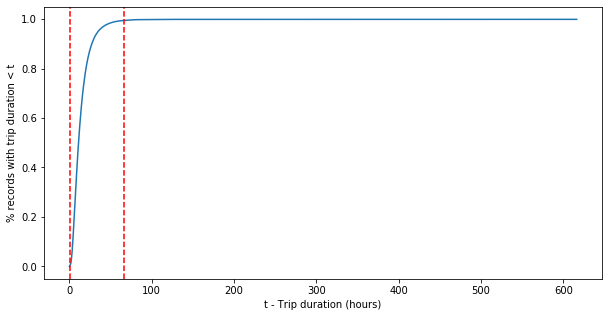

% records with duration < 1 minute: 0.65%
% records with duration > 65 minutes: 0.57%


In [31]:
steps = 500
train_data_len = 1.0 * len(train_data)

# Compute trips duration distribution
duration_upperbound = [trip_dur_min + (trip_dur_max - trip_dur_min) * ((float(i) / steps) ** 2) for i in range(0, steps)]
filtered_records = [len(train_data.index[duration_minutes <= threshold]) / train_data_len for threshold in duration_upperbound]


max_threshold = next(x for x in duration_upperbound if x > 65)
min_threshold = next(x for x in duration_upperbound if x > 1)

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(duration_upperbound, filtered_records)
ax1.set_xlabel("t - Trip duration (hours)")
ax1.set_ylabel("% records with trip duration < t")
plt.axvline(x=min_threshold, color='r', linestyle='--')
plt.axvline(x=max_threshold, color='r', linestyle='--')
print("Trip-duration CDF")
plt.show()

print("% records with duration < 1 minute: {0:.2f}%".format(100.0*filtered_records[duration_upperbound.index(min_threshold)]))
print("% records with duration > 65 minutes: {0:.2f}%".format(100.0*(1.0 - filtered_records[duration_upperbound.index(max_threshold)])))

Observing the distances of trips that had duration greater than ~1 hour, we see that the average aerial distance is 15 km approx., and however the trip duration is 6 hours approx. (with high deviation!)

A possible explanation to such pattern is a case where the taxi driver forgot to turn off the meter at the end of the trip. Of course, these records should be ommited from the training set.

In [4]:
def clean_duration_anomalies(df, duration_col):
    duration_minutes = df.apply(lambda row: row[duration_col] / 60.0, axis=1 )
    return df[(duration_minutes > 1) & (duration_minutes < 65)]

# Trip (approximated) average speed analysis

Using the ratio between the aerial distance and a trip's duration (calculated from the timestamps of turning the meter on and off) we can assess a lower bound on the average driving speed in the trip.

On one hand, too high ratio means the average speed in the trip is very high as well. When we're talking about taxi trips within a city, this ratio would have some reasonable upper bound.

On the other hand, too low ratio means the trip's duration was very long relatively to the aerial distance. We may assume the actual traveled distance linearly depends on the aerial distance, and so to give some assessment to the actual average speed in the trip. And as a result, we can give a reasonable lower bound on that average speed (e.g. it's hard to belive that an average speed of some trip would be 1 kmph). 



In [5]:
# Given the aerial distance and the trip duration, assess a lower-bound on the average-speed of the trip, for each record in the dataframe
def calc_min_avg_speed(df):
    return df.apply(lambda row: row['aerial_distance'] / (row['trip_duration_minutes'] / 60.0), axis=1 )

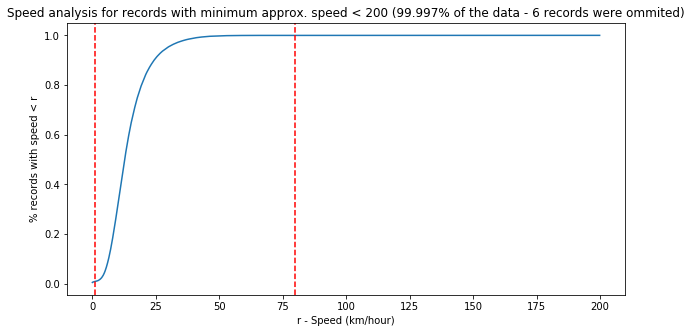

% records with ratio < 1: 0.9140%
% records with ratio > 80: 0.0145%


In [56]:
fig, ax1 = plt.subplots(figsize=(10,5))
train_data['avg_speed'] = calc_min_avg_speed(train_data)
bins_range = np.arange(train_data['avg_speed'].min(), 200, 0.1)
out, bins  = pd.cut(train_data['avg_speed'], bins=bins_range, include_lowest=True, right=False, retbins=True)
bucket_counts = out.value_counts(sort=False)
x = bins_range[:-1]
y = 1.0 * bucket_counts.values.cumsum() / len(train_data['avg_speed'])
ax1.plot(x, y)
ax1.set_xlabel("r - Speed (km/hour)")
ax1.set_ylabel("% records with speed < r")
ax1.set_title("Speed analysis for records with minimum approx. speed < 200 ({}% of the data - {} records were ommited)".format(y[-1]*100, len(train_data.loc[avg_speed_series >= 200])))
plt.axvline(x=1, color='r', linestyle='--')
plt.axvline(x=80, color='r', linestyle='--')
plt.show()

x_np = x.tolist()

print("% records with avg. speed < 1 kmph: {0:.4f}%".format(100.0*y[x_np.index(1)]))
print("% records with avg. > 80 kmph: {0:.4f}%".format(100.0*(1.0 - y[x_np.index(80)])))

In [6]:
def clean_approx_avg_speed_anomalies(df, location_cols, duration_col):
    lon1, lat1, lon2, lat2 = location_cols
    distance_series = pd.Series(haversine(df[lon1], df[lat1], df[lon2], df[lat2]))
    duration_hours_series = df[duration_col] / 3600.0
    speed_kmph_series = distance_series / duration_hours_series
    return df[(speed_kmph_series > 1) & (speed_kmph_series < 80)]

# Geographic exploration

We'd like to observe the most common pickup/dropoff locations, this might be an interesting indicator regarding the traveling time

In [41]:
dropoff_location_info_df.head(5)

lat        lon              name      admin1           admin2  cc
0  40.74482  -73.94875  Long Island City    New York    Queens County  US
1  40.71427  -74.00597     New York City    New York                   US
2  40.71427  -74.00597     New York City    New York                   US
3  40.76955  -74.02042         Weehawken  New Jersey    Hudson County  US
4  40.78343  -73.96625         Manhattan    New York  New York County  US

In [46]:
import reverse_geocoder as rg
from geopy import Nominatim

print("Example records:")
display(dropoff_location_info_df.head(3))

print("\nMost common pickup cities:")
display(pickup_location_info_df.admin1.value_counts().head(10))

# pickup_coordinates = train_data.apply(lambda row: (row['pickup_latitude'], row['pickup_longitude']), axis = 1)
# pickup_location_info_df = pd.DataFrame(rg.search([coord for coord in pickup_coordinates]))

print("\nMost common pickup locations:")
display(pickup_location_info_df.name.value_counts().head(10))


# dropoff_coordinates = train_data.apply(lambda row: (row['dropoff_latitude'], row['dropoff_longitude']), axis = 1)
# dropoff_location_info_df = pd.DataFrame(rg.search([coord for coord in dropoff_coordinates]))

print("\nMost common dropoff locations:")
display(dropoff_location_info_df.name.value_counts().head(10))

Example records:


lat        lon              name    admin1         admin2  cc
0  40.74482  -73.94875  Long Island City  New York  Queens County  US
1  40.71427  -74.00597     New York City  New York                 US
2  40.71427  -74.00597     New York City  New York                 US


Most common pickup cities:


New York            175349
New Jersey           24641
Connecticut              5
North Carolina           1
Pennsylvania             1
Washington, D.C.         1
Vermont                  1
New Hampshire            1
Name: admin1, dtype: int64


Most common pickup locations:


Manhattan           75432
New York City       58605
Long Island City    30582
Weehawken           19481
The Bronx            4923
Inwood               3680
Hoboken              2396
Guttenberg           1326
Edgewater            1288
Jamaica              1005
Name: name, dtype: int64


Most common dropoff locations:


Manhattan           74898
New York City       53058
Long Island City    33984
Weehawken           17563
Brooklyn             3530
Inwood               3030
The Bronx            2952
Edgewater            2526
Hoboken              2337
Guttenberg           1638
Name: name, dtype: int64

As can be observed, the most common pickup and dropoff locations are almost identical (and concentrated in either NYC or NJ). We'll gather the cordicates corresponding to each city and add for each record in the dataset - calculate the distance to each of these locations.

In [267]:
locator = Nominatim(user_agent="myGeocoder")
common_cities_lonlat_dict = {}
for key in pickup_location_info_df.name.value_counts()[:5].keys():
    location = locator.geocode(f"{key}, New York City")
    if location:
        print(f"{key} - {(location.longitude, location.latitude)}")
    else:
        location = locator.geocode(f"{key}, New Jersey")
        if location:
            print(f"{key} - {(location.longitude, location.latitude)}")
        else:
            print("Unknown location: ", key)
            continue
    common_cities_lonlat_dict[key] = (location.longitude, location.latitude)
    
common_locations_coor_lst = list(common_cities_lonlat_dict.values())

Manhattan - (-74.00083230730516, 40.739314199999995)
New York City - (-74.0060152, 40.7127281)
Long Island City - (-73.9569751, 40.7415095)
Weehawken - (-74.0204177, 40.7695457)
The Bronx - (-73.8785937, 40.8466508)


In [7]:
common_cities_lonlat_dict = {
    "Manhattan": (-74.00083230730516, 40.739314199999995),
    "New York City": (-74.0060152, 40.7127281),
    "Long Island City": (-73.9569751, 40.7415095),
    "Weehawken": (-74.0204177, 40.7695457),
    "The Bronx": (-73.8785937, 40.8466508)
}
common_locations_coor_lst = list(common_cities_lonlat_dict.values())

## Coordinates analysis

* Plot coordinates on a map to check for outliers outside NYC
* It can be observed two clusters of pickup/dropoff points outside New-York -- apparently, two main airports reside in those areas. Which can explain these "outliers".
 * I didn't manage to render all points on the map, so I rendered a small subset as a proof-of-concept

In [160]:
import folium
from folium.plugins import HeatMap, MarkerCluster

m = folium.Map(
    location=[train_data['pickup_latitude'].mean(), train_data['pickup_longitude'].mean()], 
    tiles='CartoDB positron', 
    zoom_start=10
)

subset_data = train_data.head(20000)

plot_individual_points = True
if not plot_individual_points:
    locations = subset_data[['pickup_latitude', 'pickup_longitude']]
    marker_cluster = MarkerCluster(locations=locations).add_to(m)
else:
    for index, row in .iterrows():
        folium.CircleMarker([row['pickup_latitude'], row['pickup_longitude']],
                            color="#0000ff", 
                            radius = 1
                           ).add_to(m)
        folium.CircleMarker([row['dropoff_latitude'], row['dropoff_longitude']],
                            color="#ff0000", 
                            radius = 1
                           ).add_to(m)

m

# store_and_forward flag analysis

I wanted to check the effect of the value of the S&F policy on the trip duration and travelled distance.

Intuitivelly, I figured that trips between distant locations would be more exposed to losing connection to the server, and thus they'll use S&F policy in those trips.

Although the sparsity of such records in the data-set, we can observe that the variance of the trip duration/aerial distance doesn't differ almost at all for travels that did or didn't use S&F policy.

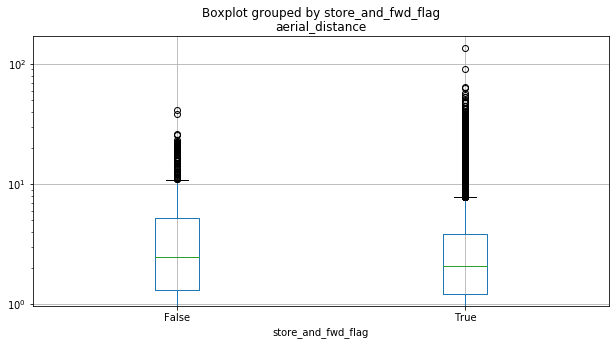

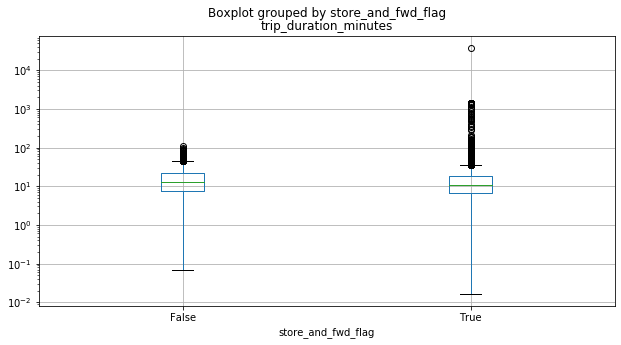

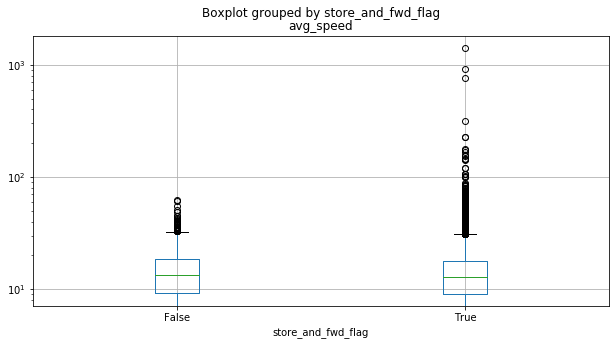

In [69]:
categories = ['aerial_distance', 'trip_duration_minutes', 'avg_speed']
# train_data['store_and_fwd_flag_bool'] = train_data['store_and_fwd_flag'] == 'Y'
snf_policy_groups = train_data.groupby(['store_and_fwd_flag_bool'])

#for data_ind, (key, group) in enumerate(snf_policy_groups):
for c in categories:
#     fig, axes = plt.subplots(nrows=1, ncols = len(snf_policy_groups))
    fig, ax = plt.subplots(figsize=(10,5))
    step = (train_data[c].max() - train_data[c].min())/15.0
    bin_range = np.arange(train_data[c].min(), train_data[c].max() + step, step)
    
    train_data.boxplot(by="store_and_fwd_flag", column=c, ax = ax)
    ax.set_yscale('log')
plt.show();

# Correlation testing

Intuitively, I'm expecting the travel time to increase as the aerial distance increases. It can be verified by checking the correlation between these values in the data. Apearently their correlation is very weak, which is very surprising.
Grouping the training data by the S&F flag dramatically increases the correlation between the driving time and the traveling distance.    

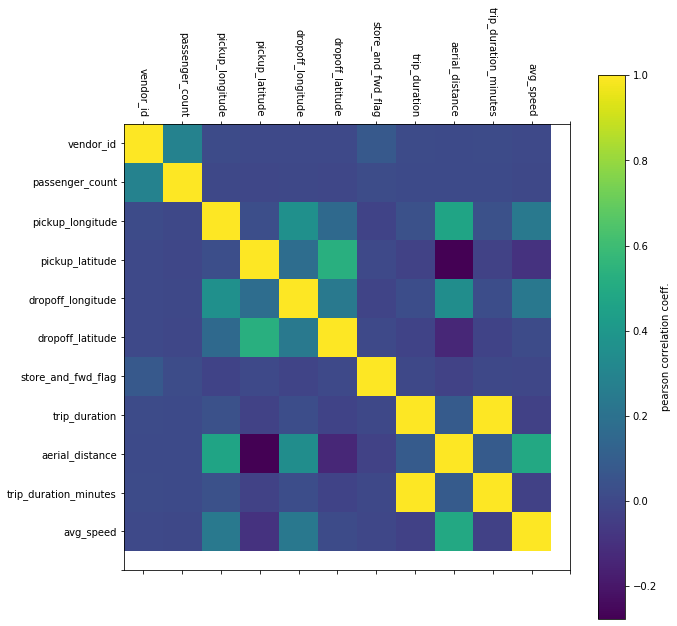

In [88]:
corr_groups = train_data.corr(method='pearson')

fig, ax = plt.subplots(figsize=(10,10))
mappable = ax.matshow(corr_groups)
plt.xticks(range(len(corr_groups.columns) + 1), corr_groups.columns, rotation=-90)
plt.yticks(range(len(corr_groups.columns) + 1), corr_groups.columns)

cb = plt.colorbar(mappable=mappable)
cb.set_label('{} correlation coeff.'.format(corr_method))

plt.show()

We can make a few observations from the correlation matrix above:
* longitude (latitude) coordinates of dropoff and pickup location are correlated - this is plausable in cases of short trips: the dropoff location should be relatively correlated with the pickup location.
* pickup and dropoff longitude coordinates is highly correlated with the aerial distance of the trip - this might indicate that short trips are less common in such locations. 
 * Short trips are more common in central districts, therefore the given correlation might indicate that these locations are non-central  (either the pickup location, or dropoff location or both).

# Clean training set

In [31]:
def clean_dataset(df, verbose=False, **kwargs):
    prev_len = len(df)
    df = clean_duration_anomalies(df, kwargs['duration_col'])
    if verbose:
        print(f"Detected {prev_len - len(df)} records with duration anomalies")
        prev_len = len(df)
    df = clean_approx_avg_speed_anomalies(df, kwargs['location_cols'], kwargs['duration_col'])
    if verbose:
        print(f"Detected {prev_len - len(df)} records with speed anomalies.")
    return df

training_df = pd.read_csv("train.csv")
print(f"Loaded training set ({len(training_df)} records)")
clean_training_df = clean_dataset(training_df, 
                            verbose=True, 
                            duration_col='trip_duration',
                            location_cols=[
                                'pickup_longitude',
                                'pickup_latitude',
                                'dropoff_longitude',
                                'dropoff_latitude'
                            ])
clean_training_df.to_csv("train_clean.csv", index=None)

In [132]:
!subsample -n 200000 train_clean.csv -r > train_clean_subsample.csv

LOG 20:17 > Data begins at 164


# Data preprocessing pipeline

## Pipeline transformers

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnTransformer(BaseEstimator, TransformerMixin):    
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[:, self.cols].reshape(-1,1)

In [9]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):        
    def __init__(self, snf_col, vendor_col):
        self.snf_col = snf_col
        self.vendor_col = vendor_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        snf_float_series = (pd.Series(X[:, self.snf_col]) == 'Y').astype(float)
        snf_float_np = snf_float_series.to_numpy()
        snf_ohe = np.array([
            snf_float_np,
            1 - snf_float_np
        ]).T
        vendor_ohe = np.array([
            X[:, self.vendor_col] == 1,
            X[:, self.vendor_col] == 2
        ]).T
        res = np.concatenate([snf_ohe, vendor_ohe], axis = 1)
        return res

In [10]:
class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        dates = pd.to_datetime(X[:, self.col])
        hours = dates.hour.values.reshape(-1,1)
        hours_one_hot = [(hours == h) for h in range(24)]
        
        dayofweeks = dates.dayofweek.values.reshape(-1,1)
        day_one_hot = [(dayofweeks == d) for d in range(7)]
        
        months = dates.month.values.reshape(-1,1)
        month_one_hot = [(months == m) for m in range(12)]
        
        is_weekend = self.is_weekend(dayofweeks)
        is_not_weekend = 1 - is_weekend
        
        is_night = self.is_night(hours)
        is_day = 1 - is_night
        res = np.concatenate([*hours_one_hot, *day_one_hot, *month_one_hot, is_weekend, is_not_weekend, is_night], axis = 1)
        return res
    
    def is_weekend(self, day):
        return (day >= 5).astype(int)
    
    def is_night(self, hour):
        return (np.logical_or((hour >= 19),(hour <= 6))).astype(int)

In [11]:
class CoordinatesTransformer(BaseEstimator, TransformerMixin):
    # Calculate the aerial distance between the trip endpoints, for each record in the dataframe
    def calc_aerial_distance(df):
        return df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1 )

    def __init__(self, cols, common_locations_lst):
        self.cols = cols
        self.common_locations_lst = common_locations_lst
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        coordinates_columns = X[:, self.cols].astype(float)
        pickup_coor = coordinates_columns.T[0:2]
        pickup_to_common_locations_distance = [haversine(*pickup_coor, *loc).reshape(-1,1) for loc in self.common_locations_lst]
        dropoff_coor = coordinates_columns.T[2:]
        dropoff_to_common_locations_distance = [haversine(*dropoff_coor, *loc).reshape(-1,1) for loc in self.common_locations_lst]
        travel_distance = haversine(*(coordinates_columns.T)).reshape(-1,1)
        return np.concatenate([
            travel_distance, 
            *pickup_to_common_locations_distance, 
            *dropoff_to_common_locations_distance
        ], axis = 1)

 # Build training pipeline

## Model evaluation helpers

In [12]:
import math

# Calculate the squared-log-error between two numbers
def sle(y, y_pred):
    return (math.log(y_pred + 1) - math.log(y + 1)) ** 2.0


# Calculate the Root-Mean-Squared-Log-Error function between two vectors
def rmsle(y_true, y_pred):
    y_pred = y_pred.clip(min=0)
    terms_to_sum = [sle(y_pred[i], y_true[i]) for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y_true))) ** 0.5


def plot_predictions_accuracy(y, y_pred, label = None, log_scale = True):
    fig, ax = plt.subplots()
    ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    if label is not None:
        ax.set_title(label)
    plt.show()

## Pipeline

In [13]:
from sklearn.model_selection import train_test_split

# Load dataset from csv (assuming that label is the last column)
def load_dataset(fpath, random_state=17, test_size=0.2):
    data_df = pd.read_csv(fpath)
    
    if test_size == 0: # just create a dataframe and convert to numpy arrays
        data = data_df.to_numpy()
        X = data[:, :-2]
        y = data[:, -1]
        return data_df, X, y
    
    train_df, test_df = train_test_split(data_df, test_size=test_size, random_state=random_state)
    
    X = {}
    y = {}
    df = {'train': train_df, 'test': test_df}
    for name, name_df in df.items():
        data = name_df.to_numpy()
        X[name] = data[:, :-2]
        y[name] = data[:, -1]
        
    return df, X, y

In [16]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import linear_model, ensemble

preprocess_pipeline = Pipeline([
    ('feature_cat', FeatureUnion([
        ('date', DateTransformer(col=pickup_dt_idx)),
        ('location', CoordinatesTransformer(cols=coordinates_indices, common_locations_lst=common_locations_coor_lst)),
        ('categorical_features', CategoricalTransformer(snf_col=snf_flag_idx, vendor_col=vendor_idx)),
        ('passenger_count', ColumnTransformer(cols=[passanger_count_idx]))
    ]))
])

regressors = [
    linear_model.LinearRegression(),
    ensemble.GradientBoostingRegressor(),
    ensemble.AdaBoostRegressor(base_estimator=linear_model.LinearRegression())
]


date_features = [
    *[f"is_hour_{h}" for h in range(24)],
    *[f"is_dayofweek_{d}" for d in range(7)],
    *[f"is_month_{m}" for m in range(12)],
    'is_weekend',
    'is_not_weekend',
    'is_night'
]

coordinates_features = [
    'travel_distance',
    *[f"pickup_to_{loc.replace(' ', '_')}_distance" for loc in common_cities_lonlat_dict.keys()],
    *[f"dropoff_to_{loc.replace(' ', '_')}_distance" for loc in common_cities_lonlat_dict.keys()]
]
categorical_feature_names = ['snf_on', 'snf_off', 'vendor_1', 'vendor_2']

model_feature_names = [
    *date_features,
    *coordinates_features,
    *categorical_feature_names,
    'passenger_count'
]

LinearRegression train-set RMSLE loss: 0.49
LinearRegression test-set RMSLE loss: 0.49


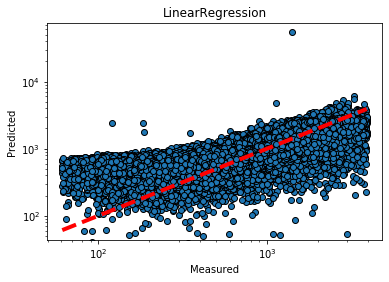

GradientBoostingRegressor train-set RMSLE loss: 0.38
GradientBoostingRegressor test-set RMSLE loss: 0.38


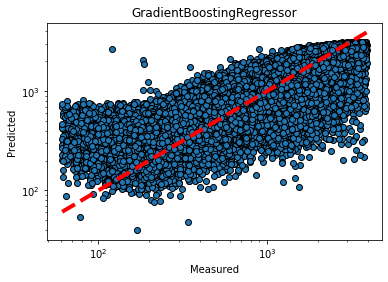

AdaBoostRegressor train-set RMSLE loss: 0.63
AdaBoostRegressor test-set RMSLE loss: 0.63


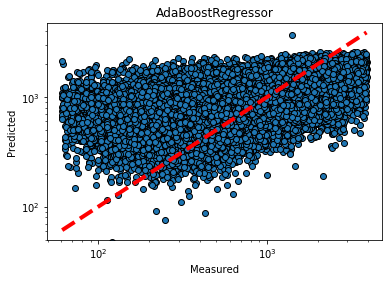

In [273]:
fitted_regressors = []
results = {}

df, X, y = load_dataset("train_clean.csv")

for reg in regressors:
    pipe = Pipeline(steps=[
        ('preprocessor', preprocess_pipeline),
        ('regressor', reg)
    ])
    # train
    pipe.fit(X['train'], y['train'])
    fitted_regressors.append(reg)
    
    # evaluate
    curr_result = {'train': {}, 'test': {}}
    for dataset_type in ['train', 'test']:
        y_pred = pipe.predict(X[dataset_type])
        if False and any(y_pred < 0): # clip negative values (which can't be evaluated in RMSLE loss)
            print(f"Detected {sum(y_pred < 0)} negative values")
        y_true = y[dataset_type]
        curr_result[dataset_type]['score'] = rmsle(y_true, y_pred)

        print(f"{type(reg).__name__} {dataset_type}-set RMSLE loss: %.2f" % curr_result[dataset_type]['score'])
        
        # Save predictions for error analysis later
        curr_result[dataset_type]['pred'] = pd.Series(y_pred)
        
        # Plot test set accuracy
        if dataset_type == 'test':
            plot_predictions_accuracy(y_true, y_pred, label= type(reg).__name__, log_scale=True)
        
        results[type(reg).__name__] = curr_result

## Tuning best model's hyperparameters

Considering our most accurate model (i.e. GB regressor), we'll make a more refined exploration for optimal hyperparameters
* I'll use a naive grid-search exploration (however any other tine-tuning platform should work as well)

In [17]:
preprocess_pipeline = Pipeline([
    ('feature_cat', FeatureUnion([
        ('date', DateTransformer(col=pickup_dt_idx)),
        ('location', CoordinatesTransformer(cols=coordinates_indices, common_locations_lst=common_locations_coor_lst)),
        ('categorical_features', CategoricalTransformer(snf_col=snf_flag_idx, vendor_col=vendor_idx)),
        ('passenger_count', ColumnTransformer(cols=[passanger_count_idx]))
    ]))
])

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

_, X, y = load_dataset("train_clean.csv", test_size=0)

best_pipe = Pipeline(steps=[
        ('preprocessor', preprocess_pipeline),
        ('regressor', ensemble.GradientBoostingRegressor())
    ])

param_grid = {
    'regressor__learning_rate': [0.01, 0.1, 0.5],
    'regressor__n_estimators': [100]
}

cv = GridSearchCV(
    best_pipe,
    param_grid,
    scoring=make_scorer(rmsle),
    verbose=10,
    n_jobs=-1,
    cv=3 # use 3 folds
)

result = cv.fit(X, y)
result

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed: 22.1min remaining: 44.3min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 22.2min remaining: 27.7min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed: 45.4min remaining: 36.3min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 45.4min remaining: 22.7min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 45.4min remaining: 13.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 60.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 60.4min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('feature_cat',
                                                         FeatureUnion(transformer_list=[('date',
                                                                                         DateTransformer(col=2)),
                                                                                        ('location',
                                                                                         CoordinatesTransformer(cols=range(4, 8),
                                                                                                                common_locations_lst=[(-74.00083230730516,
                                                                                                                                       40.739314199999995),
                                                                                                    

## Plot feature importance

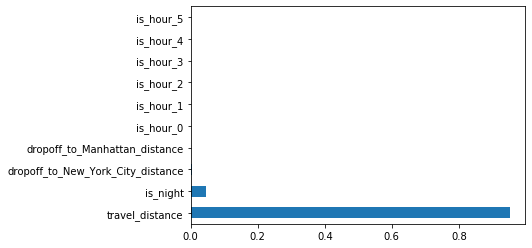

In [26]:
pd.Series(result.best_estimator_.named_steps['regressor'].feature_importances_, index=model_feature_names).nlargest(10).plot(kind='barh')

It can be observed that the most dominant feature in the model is the estimated travel distance, the distance to common cities, and wether the trip was made at night or during the day.
 * It can be concluded that the raw features that were extracted from the dataset aren't very informative, therefore we should go back to the feature engineering process in order to look for better features.

# Error analysis (w.r.t. time-of-day)

We'd like to check whether the model tends to be less accurate in specific days/months than others. We might infer the use-cases which were not generalized well by the model.

In [379]:
pickup_dt_series = pd.to_datetime(df['test']['pickup_datetime'])
pickup_month_series = pickup_dt_series.dt.month
pickup_weekday_series = pickup_dt_series.dt.weekday
pickup_week_series = pickup_dt_series.dt.week
pickup_day_series = pickup_dt_series.dt.day
pickup_hour_series = pickup_dt_series.dt.hour

y_true = df['test']['trip_duration']

# get y_pred using the best model (i.e. GradientBoostingRegressor)
pipe = Pipeline(steps=[
    ('preprocessor', preprocess_pipeline),
    ('regressor', result.best_estimator_.named_steps['regressor'])
])
y_pred = pipe.predict(X['test'])

def get_group_loss_series(y_true, y_pred, x_col, x_values, base_filter=True):
    err_val = []
    for x_val in x_values:
        y_true_filtered = y_true[base_filter & (x_col == x_val)].values
        y_pred_filtered = y_pred[base_filter & (x_col == x_val)]
        err_val.append(rmsle(y_true_filtered, y_pred_filtered))
    return err_val

def plot_feature_dependency_loss(gt, pred, x_col, x_name, x_values, x_col_str_format, group_col=None, group_name=None, group_values=None):
    x_labels = [x_col_str_format.format(x) for x in x_values]
    err_val = []
    fig, ax = plt.subplots(figsize=(25, 5))
    
    if group_values:
        for group_val in group_values:
            err_val = get_group_loss_series(y_true=y_true, y_pred=y_pred, x_col=x_col, x_values=x_values,
                                            base_filter=(group_col == group_val))
            x_range = range(len(x_values))
            ax.plot(x_range, err_val, label=f"{group_name} {group_val}")
    else:
        err_val = get_group_loss_series(y_true=y_true, y_pred=y_pred, x_col=x_col, x_values=x_values)
        x_range = range(len(x_values))
        ax.plot(x_range, err_val)

    plt.xticks(x_range, x_labels, rotation=60)
    ax.set_title(f"RMSLE({x_name})")
    ax.set_xlabel(x_name)
    ax.set_ylabel("RMSLE score")
    plt.legend()
    plt.show()

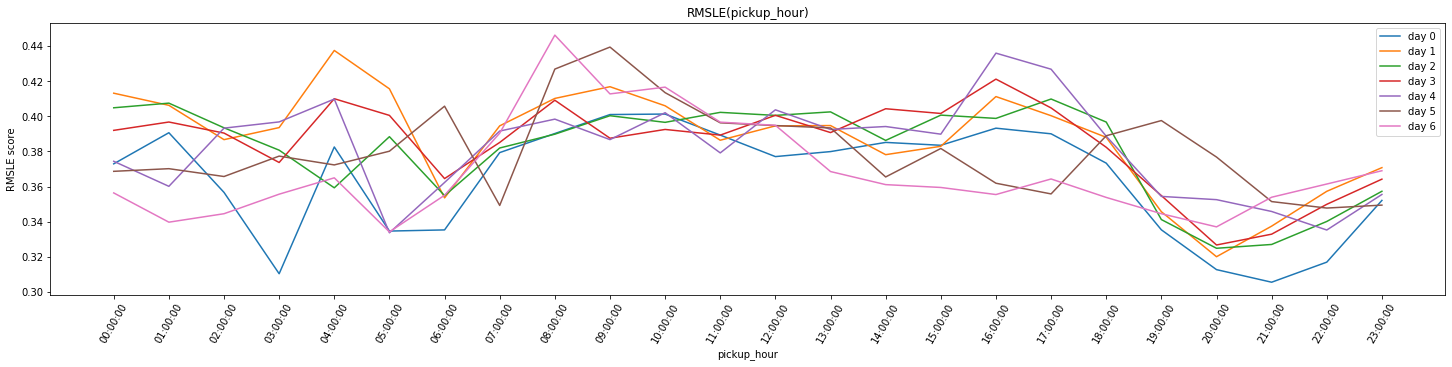

In [380]:
plot_feature_dependency_loss(
    gt=y_true,
    pred=y_pred,
    x_col=pickup_hour_series,
    x_name="pickup_hour",
    x_values=range(24),
    group_col=pickup_weekday_series,
    group_name="day",
    group_values=range(7),
    x_col_str_format="{0:02d}:00:00"
)

* Predictions are mostly inaccurate at traffic hours (7:00 - 19:00)
* Prediction gets more accurate for trips with high aerial distance between the pickup location and the destination
* There's a weak correlation between the trip duration and the aerial distance

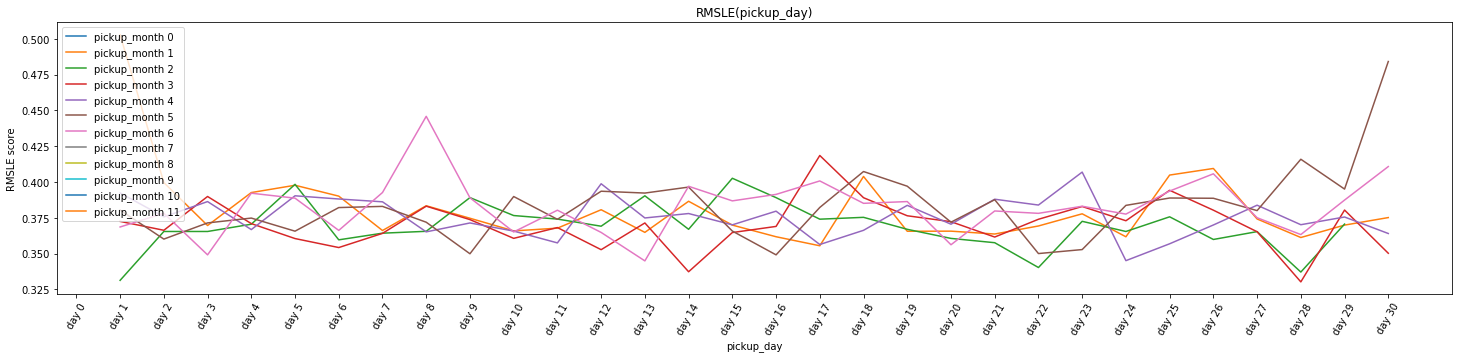

In [381]:
plot_feature_dependency_loss(
    gt=y_true,
    pred=y_pred,
    x_col=pickup_day_series,
    x_name="pickup_day",
    x_values=range(31),
    group_col=pickup_month_series,
    group_name="pickup_month",
    group_values=range(12),
    x_col_str_format="day {}"
)

* No significant variance in the model's accuracy in different months